In [2]:
import numpy as np
from numpy import ndarray as arr
import torch
from torch import nn, optim
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
pd_data: pd.DataFrame = pd.read_csv("data.csv")

data = np.array(pd_data)

del pd_data

In [3]:
np.random.shuffle(data)

data_test: arr = data[:2000] # (2000, 785)
x_test: arr = data_test[:, 1:] / 255.0 # (2000, 784)
y_test: arr = data_test[:, 0] # (2000, 1)

data_train: arr = data[2000:] # (40000, 785)
x_train: arr = data_train[:, 1:] / 255.0 # (40000, 784)
y_train: arr = data_train[:, 0] # (40000, 1)

del data, data_test, data_train

In [ ]:
def leakyRelU(x: arr, alpha: float = 0.01) -> arr:
    return np.where(x > 0, x, alpha * x)


def leakyRelUDeriv(x: arr, alpha: float = 0.01) -> arr:
    return np.where(x > 0, 1, alpha)


def softMax(x: arr) -> arr:
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)


def init_parms() -> list[list[arr]]:
    w1: arr = np.random.rand(784, 10) - 0.5
    b1: arr = np.random.rand(1, 10) - 0.5

    w2: arr = np.random.rand(10, 20) - 0.5
    b2: arr = np.random.rand(1, 20) - 0.5

    w3: arr = np.random.rand(20, 10) - 0.5
    b3: arr = np.random.rand(1, 10) - 0.5

    return [[w1, b1], [w2, b2], [w3, b3]]


def forward_prop(nn: list[list[arr]], x: arr) -> list[list[arr]]:
    outputs: list[list[arr]] = []

    for i, (w,b) in enumerate(nn):
        inp: arr = outputs[-1][1] if outputs else x

        z: arr = inp @ w + b
        a: arr = (leakyRelU if i != len(nn) - 1 else softMax)(z)

        outputs.append([z, a])

    return outputs


def one_hot(y: arr) -> arr:
    return np.eye(np.max(y) + 1)[y]

def back_prop(nn: list[list[arr]], outputs: list[list[arr]], x: arr, y: arr) -> list[list[arr]]:
    gradient: list[list[arr]] = []
    z_deltas: list[arr] = []

    for i in range(len(nn) - 1, -1, -1):
        z, a = outputs[i]

        if z_deltas:
            dz = z_deltas[-1].dot(nn[i + 1][0].T) * leakyRelUDeriv(z)
        else:
            dz = a - one_hot(y)
        
        z_deltas.append(dz)
        
        dw = 1 / y.size * dz.T @ (outputs[i - 1][0] if i > 0 else x)
        db = 1 / y.size * np.sum(dz)

        gradient.append([dw, db])

    return gradient[::-1]

t = 0
m_dw = [np.zeros((784, 10)), np.zeros((10, 20)), np.zeros((20, 10))]
m_db = [np.zeros((1, 10)), np.zeros((1, 20)), np.zeros((1, 10))]

v_dw = [np.zeros((784, 10)), np.zeros((10, 20)), np.zeros((20, 10))]
v_db = [np.zeros((1, 10)), np.zeros((1, 20)), np.zeros((1, 10))]

epsilon = 1e-8

def update_params(nn: list[list[arr]], gradient: list[list[arr]], learning_rate: float = 0.05) -> None:
    assert len(nn) == len(gradient)

    beta1 = 0.9
    beta2 = 0.999



    for i, (dw, db) in enumerate(gradient):
        m_dw[i] = beta1 * m_dw[i] + (1 - beta1) * dw.T
        m_db[i] = beta1 * m_db[i] + (1 - beta1) * db.T
        v_dw[i] = beta2 * v_dw[i] + (1 - beta2) * dw.T ** 2
        v_db[i] = beta2 * v_db[i] + (1 - beta2) * db.T ** 2

        m_dw_corr = m_dw[i] / (1 - beta1 ** t)
        m_db_corr = m_db[i] / (1 - beta1 ** t)
        v_dw_corr = v_dw[i] / (1 - beta2 ** t)
        v_db_corr = v_db[i] / (1 - beta2 ** t)

        m_dw_corr[m_dw_corr < 0] = 0
        m_db_corr[m_db_corr < 0] = 0
        v_dw_corr[v_dw_corr < 0] = 0
        v_db_corr[v_db_corr < 0] = 0

        nn[i][0] -= learning_rate * (m_dw_corr / (np.sqrt(v_dw_corr) + epsilon))
        nn[i][1] -= learning_rate * (m_db_corr / (np.sqrt(v_db_corr) + epsilon))


def get_predictions(out: arr) -> arr:
    return np.argmax(out, axis=1)

def get_accuracy(predictions: arr, actual: arr) -> arr:
    return 100 * (np.sum(predictions == actual) / actual.size)


def gradient_descent(nn: list[list[arr]], x: arr, y: arr, iterations: int = 1000) -> None:
    print_freq = (int) (iterations / 50)

    for i in range(iterations):
        out = forward_prop(nn, x)

        grad = back_prop(nn, out, x, y)

        global t
        t += 1
    
        update_params(nn, grad)
        
        if i % print_freq == 0:
            print(f"Epoch {i}")
            print(f"Accuracy: {get_accuracy(get_predictions(out[-1][1]), y):.2f}%")

nn = init_parms()
gradient_descent(nn, x_train, y_train, 2000)


In [5]:
def predict(nn: list[list[arr]], x: arr) -> arr:
    return get_predictions(forward_prop(nn, x)[-1][1])

predictions = predict(nn, x_test)

print(f"Test data accuracy: {get_accuracy(predictions, y_test):.2f}%")

Test data accuracy: 87.00%


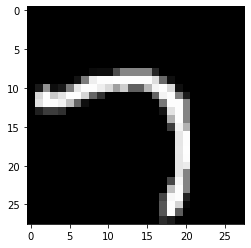

Prediction: 7
Label: 7


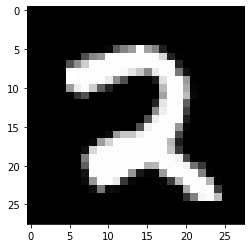

Prediction: 2
Label: 2


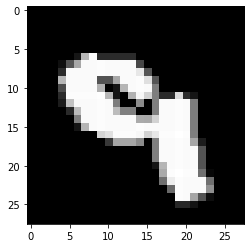

Prediction: 4
Label: 9


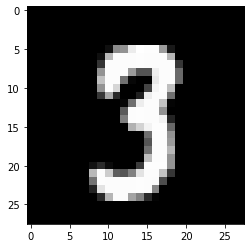

Prediction: 3
Label: 3


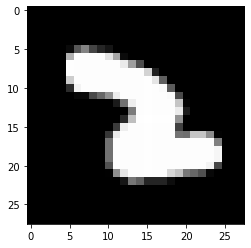

Prediction: 2
Label: 2


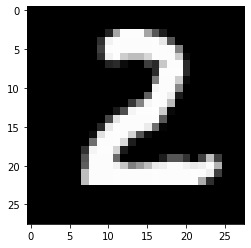

Prediction: 2
Label: 2


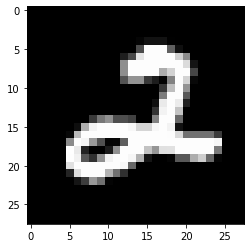

Prediction: 2
Label: 2


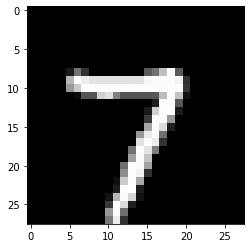

Prediction: 7
Label: 7


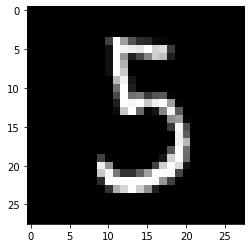

Prediction: 5
Label: 5


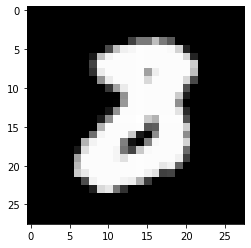

Prediction: 3
Label: 8


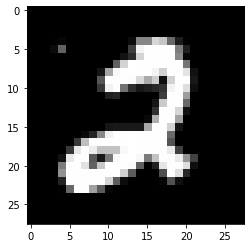

Prediction: 2
Label: 2


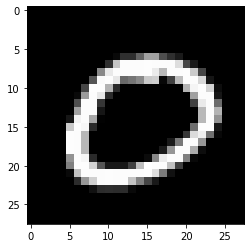

Prediction: 0
Label: 0


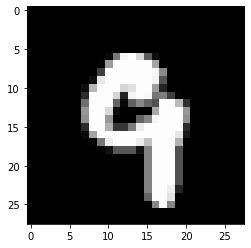

Prediction: 9
Label: 9


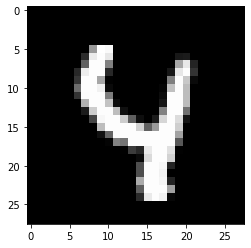

Prediction: 4
Label: 4


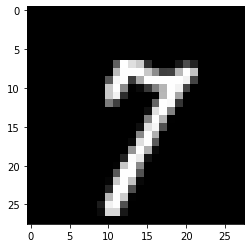

Prediction: 7
Label: 7


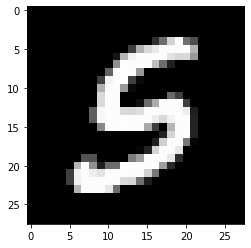

Prediction: 5
Label: 5


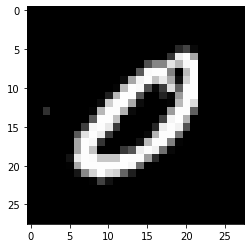

Prediction: 0
Label: 0


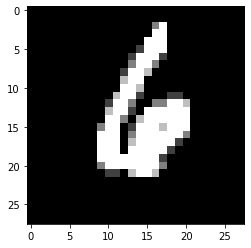

Prediction: 6
Label: 6


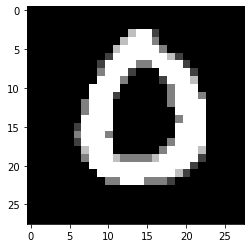

Prediction: 0
Label: 0


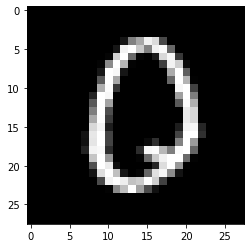

Prediction: 0
Label: 0


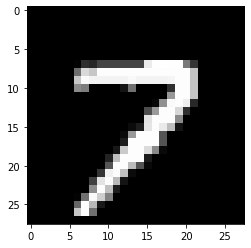

Prediction: 7
Label: 7


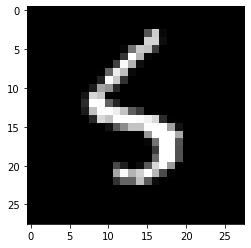

Prediction: 6
Label: 5


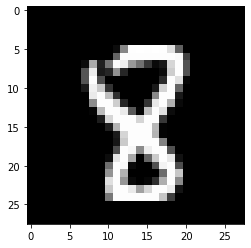

Prediction: 8
Label: 8


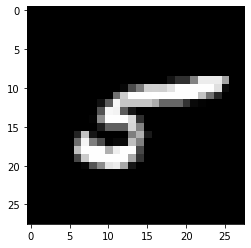

Prediction: 8
Label: 5


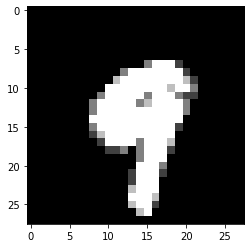

Prediction: 9
Label: 9


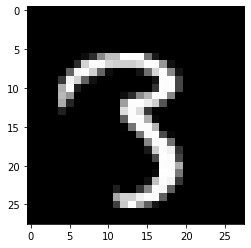

Prediction: 3
Label: 3


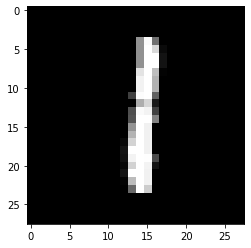

Prediction: 1
Label: 1


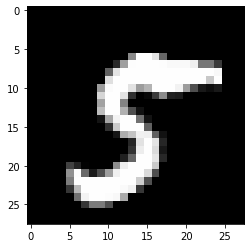

Prediction: 5
Label: 5


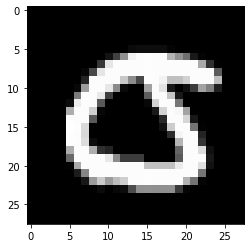

Prediction: 0
Label: 0


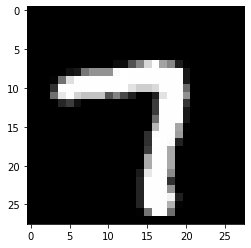

Prediction: 7
Label: 7


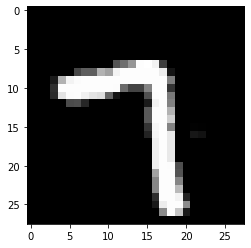

Prediction: 7
Label: 7


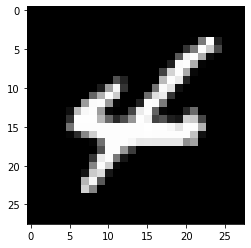

Prediction: 4
Label: 4


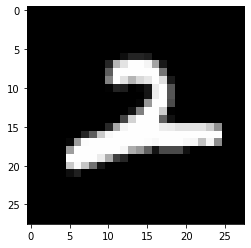

Prediction: 2
Label: 2


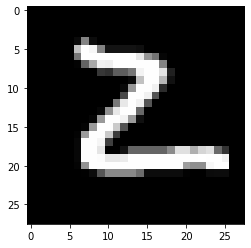

Prediction: 2
Label: 2


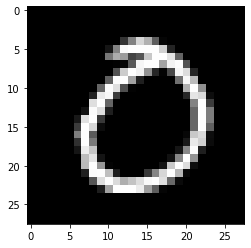

Prediction: 0
Label: 0


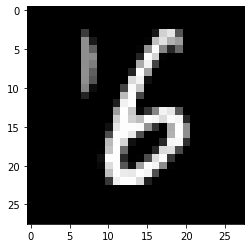

Prediction: 6
Label: 6


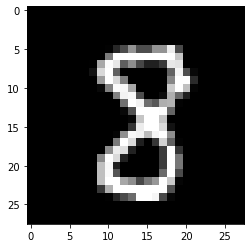

Prediction: 8
Label: 8


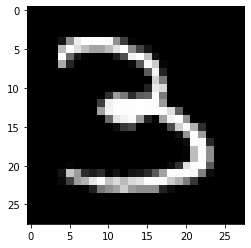

Prediction: 3
Label: 3


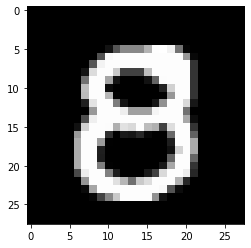

Prediction: 8
Label: 8


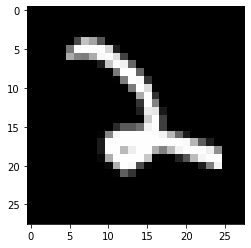

Prediction: 2
Label: 2


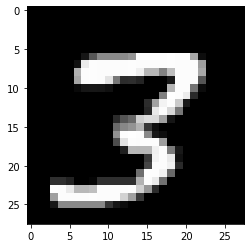

Prediction: 3
Label: 3


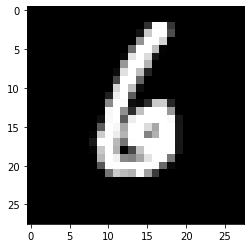

Prediction: 6
Label: 6


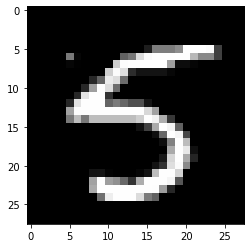

Prediction: 5
Label: 5


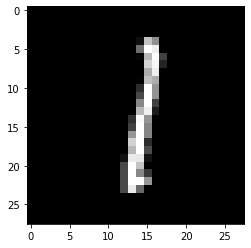

Prediction: 4
Label: 1


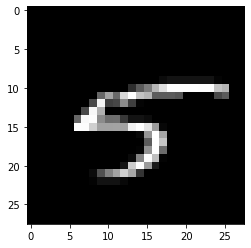

Prediction: 4
Label: 5


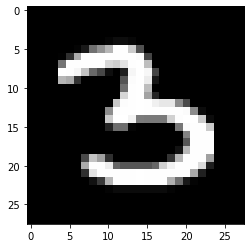

Prediction: 3
Label: 3


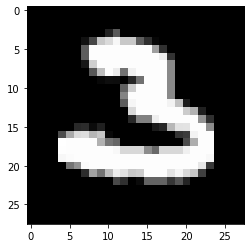

Prediction: 2
Label: 3


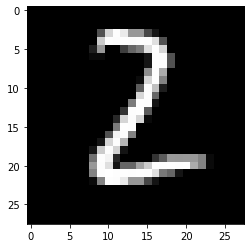

Prediction: 2
Label: 2


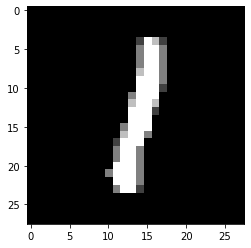

Prediction: 1
Label: 1


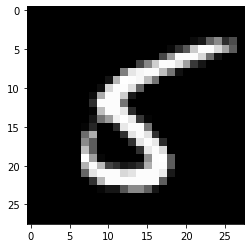

Prediction: 5
Label: 5


In [6]:
for img, p, lbl, _ in zip(x_test, predictions, y_test, range(50)):
    plt.gray()
    plt.imshow(img.reshape((28, 28)) * 255)
    plt.show()
    print(f"Prediction: {p}")
    print(f"Label: {lbl}")
